In [1]:
# Uninstall fastai for solving dependence problems
!pip uninstall fastai -y
# Install packages without internet
!pip install ../input/packages/torch-1.7.1-cp37-cp37m-manylinux1_x86_64.whl
!pip install ../input/packages/torchvision-0.8.2-cp37-cp37m-manylinux1_x86_64.whl

Found existing installation: fastai 2.0.19
Uninstalling fastai-2.0.19:
  Successfully uninstalled fastai-2.0.19
Processing /kaggle/input/packages/torch-1.7.1-cp37-cp37m-manylinux1_x86_64.whl
  Attempting uninstall: torch
    Found existing installation: torch 1.6.0
    Uninstalling torch-1.6.0:
      Successfully uninstalled torch-1.6.0
Processing /kaggle/input/packages/torchvision-0.8.2-cp37-cp37m-manylinux1_x86_64.whl
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.7.0
    Uninstalling torchvision-0.7.0:
      Successfully uninstalled torchvision-0.7.0


In [2]:
import sys
sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')
sys.path.append('../input/pytorch-optimizers/')
sys.path.append('../input/repvgg/')
sys.path.append('../input/repvggmodels/')
sys.path.append('../input/bi-tempered-loss/')

import timm
import bi_tempered_loss
from torch_optimizer.radam import RAdam
from repvgg import RepVGG, create_RepVGG_B3g4, create_RepVGG_B3, repvgg_model_convert

In [3]:
import os
import cv2
import time
import copy
import random
import joblib
import sklearn
import warnings
import multiprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from skimage import io
from sklearn import metrics
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss
from IPython.display import display
from catalyst.data.sampler import BalanceClassSampler

import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.nn.modules.loss import _WeightedLoss
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import models
from torchvision import transforms

from albumentations.pytorch import ToTensor, ToTensorV2
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout,
    ShiftScaleRotate, CenterCrop, Resize)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [4]:
# Move some weights to torch cache dir
cache_dir = os.path.expanduser(os.path.join('~', '.cache/torch/hub/checkpoints'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
!cp ../input/pretrained-pytorch-models/* ~/.cache/torch/hub/checkpoints/

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [6]:
CFG = {
    'fold_num': 3,
    'seed'    : 42,
    'img_size': 400,
    'epochs'  : 17,
    'train_bs': 16,
    'valid_bs': 32,
    'T_0'     : 20,
    'lr'      : 0.001,
    'momentum': 0.9,
    'min_lr'  : 1e-6,
    'weight_decay'   : 1e-4,
    'num_workers'    : 4,
    'accum_iter'     : 2, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'early_stopping' : 10,
    'verbose_step'   : 1,
    #'device': 'cpu'}
    'device': 'cuda:0'}

In [7]:
train      = pd.read_csv('../input/cassava-noised-label-data/noised_label_data.csv')
submission = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')
display(train.head(2))
display(submission.head())

image_id  label  label_0  label_1  label_2  label_3  label_4
0  1001320321.jpg      0      1.0      0.0      0.0      0.0      0.0
1  1012426959.jpg      0      1.0      0.0      0.0      0.0      0.0

image_id  label
0  2216849948.jpg      4

In [8]:
print(train.shape)
train.label.value_counts()

(21397, 7)


3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [9]:
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

def show_images(names):
    c = 4
    r = int(np.ceil(len(names) / c))
    fig, axes = plt.subplots(nrows=r, ncols=c, figsize=(14, len(names)-3))
    cnt = 0
    for i in range(r):
        for j in range(c):
            if len(names)<=cnt: continue
            img = get_img(f"../input/cassava-leaf-disease-classification/train_images/{names[cnt]}")
            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            cnt += 1
    fig.show()

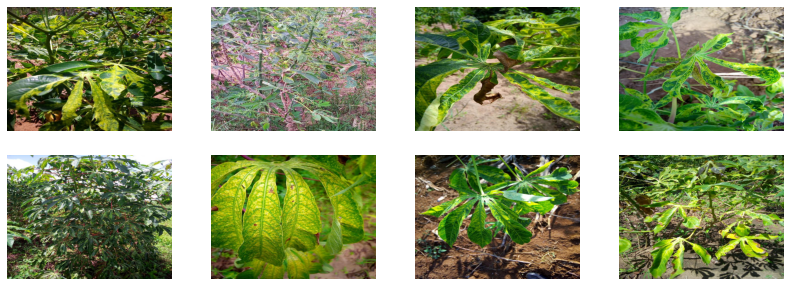

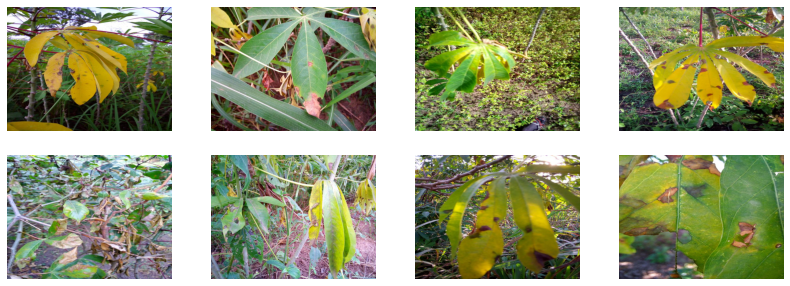

In [10]:
show_num = 8
# Label 0 with low prob
show_images(list(train[train.label==0].sort_values("label_0").iloc[:show_num,0]))
# Label 0 with high prob
show_images(list(train[train.label==0].sort_values("label_0").iloc[-show_num:,0]))

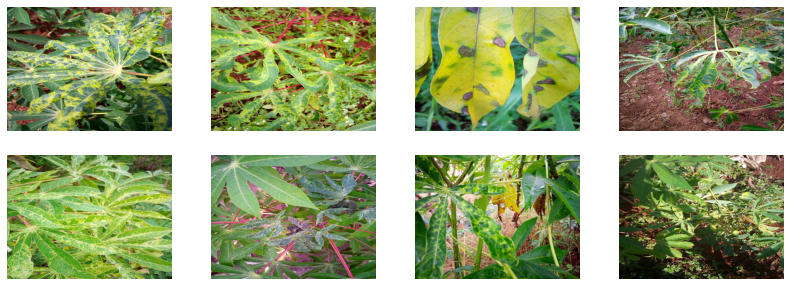

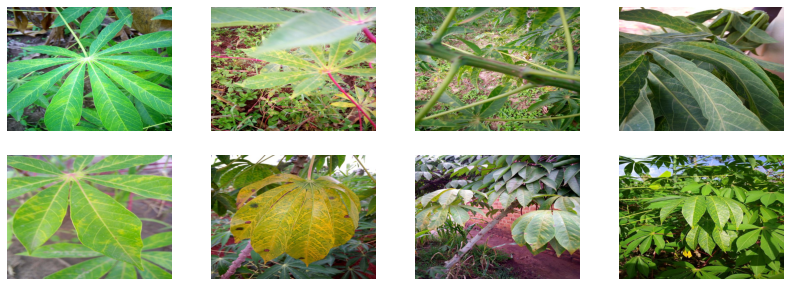

In [11]:
# Label 1 with low prob
show_images(list(train[train.label==1].sort_values("label_1").iloc[:show_num,0]))
# Label 1 with high prob
show_images(list(train[train.label==1].sort_values("label_1").iloc[-show_num:,0]))

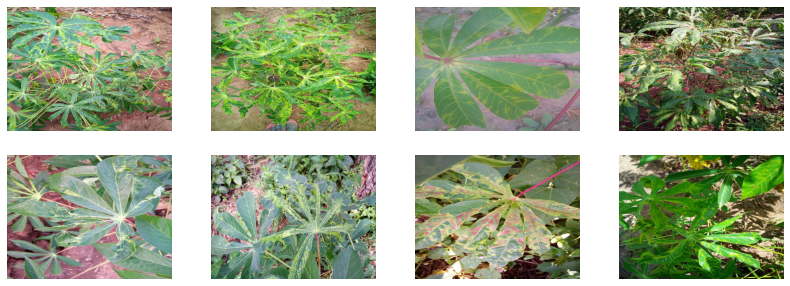

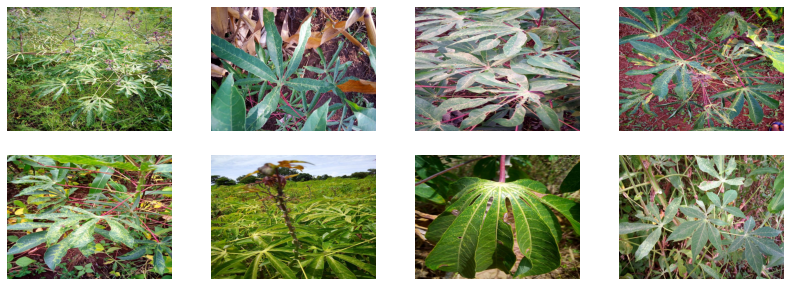

In [12]:
# Label 2 with low prob
show_images(list(train[train.label==2].sort_values("label_2").iloc[:show_num,0]))
# Label 2 with high prob
show_images(list(train[train.label==2].sort_values("label_2").iloc[-show_num:,0]))

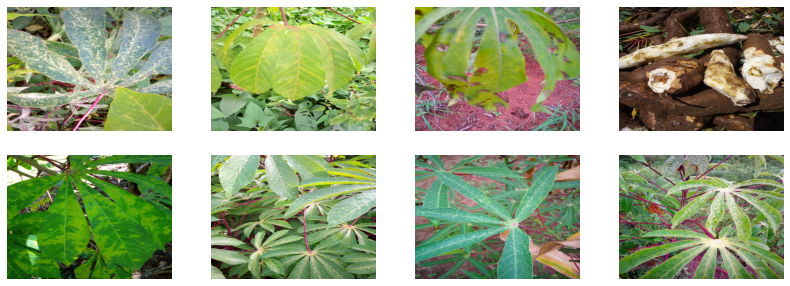

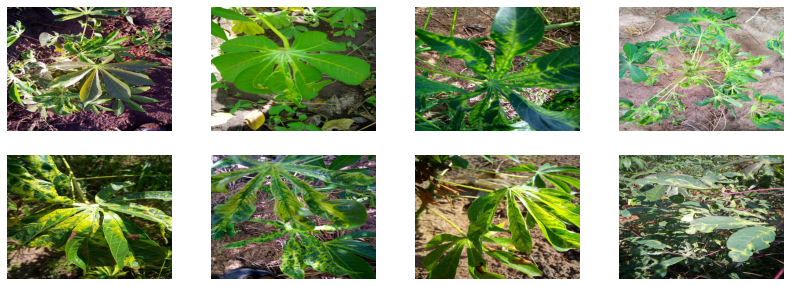

In [13]:
# Label 3 with low prob
show_images(list(train[train.label==3].sort_values("label_3").iloc[:show_num,0]))
# Label 3 with high prob
show_images(list(train[train.label==3].sort_values("label_3").iloc[-show_num:,0]))

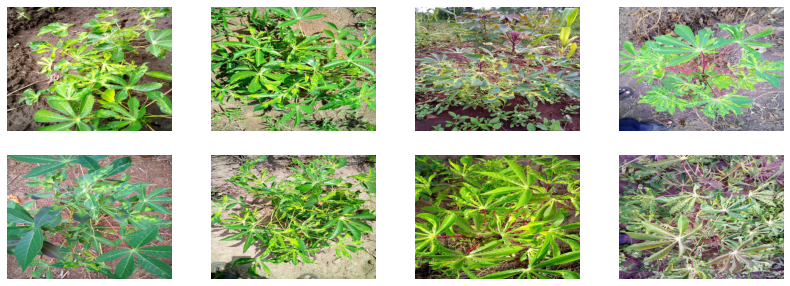

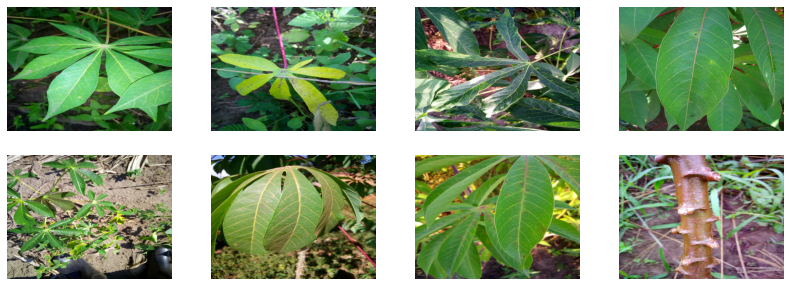

In [14]:
# Label 4 with low prob
show_images(list(train[train.label==4].sort_values("label_4").iloc[:show_num,0]))
# Label 4 with high prob
show_images(list(train[train.label==4].sort_values("label_4").iloc[-show_num:,0]))

# Preparation for labels with smooth

In [15]:
def do_label_smooth(df, label, thr):
    df = df.copy()
    smooth_labels    = []
    not_target_label = np.delete(np.arange(5), label)
    for row in np.array(df.loc[(df.label==label)&(df[f"label_{label}"] < thr)])[:,2:]:
        r = row.copy()
        d = (thr - row[label]) / 4
        r[not_target_label] = row[not_target_label] - d
        r[label] = thr
        while True:
            if 0 <= r[not_target_label].min():
                break
            r[not_target_label] = np.abs(r[not_target_label])
            d = (sum(r) - 1) / 4
            r[not_target_label] = r[not_target_label] - d
        smooth_labels.append(r.tolist())
    df.loc[(df.label==label)&(df[f"label_{label}"] < thr), [f"label_{l}" for l in range(5)]] = smooth_labels
    return df

In [16]:
thr = 0.7
for label in range(5):
    train = do_label_smooth(train, label, thr)

In [17]:
for label in range(5):
    train.loc[(train["label"]==label)&(train[f"label_{label}"]>thr), f"label_{label}"] = 1

In [18]:
thr = 0.9
num_classes     = 5
label_smoothing = 0.1
target_label    = [f"label_{l}" for l in range(5)]
for label in range(5):
    labels = np.array(train.loc[train[f"label_{label}"]>thr, target_label])
    labels = (1 - num_classes / (num_classes - 1) * label_smoothing) * labels + label_smoothing / (num_classes - 1)
    train.loc[train[f"label_{label}"]>thr, target_label] = labels

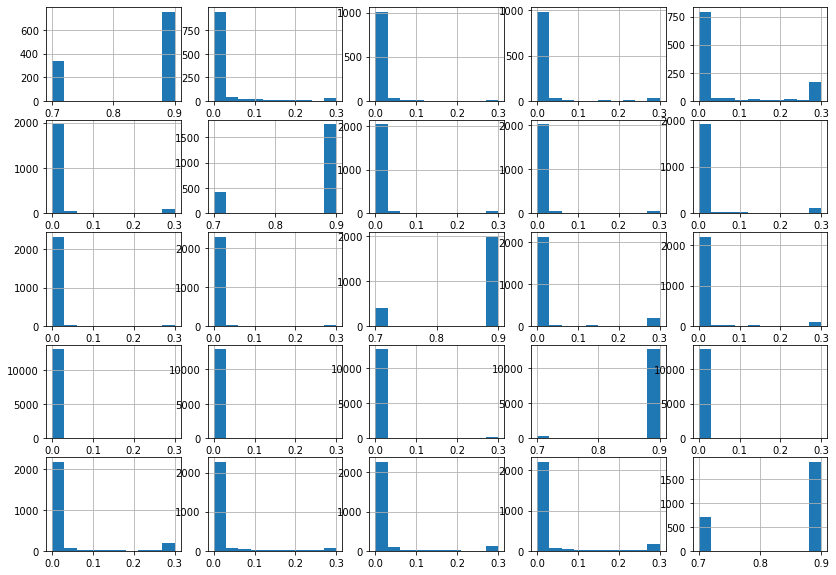

In [19]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(14, 10))
for r in range(5):
    m = round(train[train.label==r].shape[0],-2)
    for c in range(5):
        train[train.label==r][f"label_{c}"].hist(ax=axes[r,c])

# Train with pre-trained weights

In [20]:
class CassavaDataset(Dataset):
    def __init__(self, df, data_root, 
                 transforms=None, 
                 output_label=True, 
                 one_hot_label=False,
                 do_fmix=False, 
                 fmix_params={'alpha'      : 1., 
                              'decay_power': 3., 
                              'shape'      : (CFG['img_size'], CFG['img_size']),
                              'max_soft'   : True, 
                              'reformulate': False},
                 do_cutmix=False,
                 cutmix_params={'alpha': 1}):
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms  = transforms
        self.data_root   = data_root
        self.do_fmix     = do_fmix
        self.fmix_params = fmix_params
        self.do_cutmix   = do_cutmix
        self.cutmix_params = cutmix_params
        self.output_label  = output_label
        self.one_hot_label = one_hot_label
        
        if output_label:
            # Get one hot labels
            self.soft_labels = self.df[[f"label_{l}" for l in range(5)]].values
            self.hard_labels = self.df.label.values
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            soft_target = self.soft_labels[index]
            hard_target = self.hard_labels[index]
        img = get_img(f"{self.data_root}/{self.df.loc[index]['image_id']}")
        
        if self.transforms:
            img = self.transforms(image=img)['image']
        
        if self.output_label:
            return img, soft_target, hard_target
        else:
            return img

In [21]:
def get_train_transforms():
    return Compose([
            RandomResizedCrop(CFG['img_size'], CFG['img_size']),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0)], p=1)
  
def get_valid_transforms():
    return Compose([
            CenterCrop(CFG['img_size'], CFG['img_size'], p=1.),
            Resize(CFG['img_size'], CFG['img_size']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0)], p=1)

In [22]:
#backbone = models.resnet50(pretrained=False)
#backbone.load_state_dict(torch.load("../input/byol-model/byol.pt"))

In [23]:
backbone = create_RepVGG_B3g4(deploy=False)
#backbone.load_state_dict(torch.load('../input/repvgg/RepVGG-B3g4-200epochs-train.pth', map_location=torch.device("cpu")))
backbone.load_state_dict(torch.load('../input/repvgg/RepVGG-B3g4-200epochs-train.pth'))

RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identi

<All keys matched successfully>

In [24]:
class FFN(nn.Module):
    def __init__(self):
        super(FFN, self).__init__()
        self.backbone = backbone
        self.lr1      = nn.Linear(1000, 256)
        self.relu     = nn.ReLU()
        self.dropout  = nn.Dropout(0.5)
        self.lr2      = nn.Linear(256, 5)
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.relu(self.lr1(x))
        x = self.dropout(x)
        x = self.lr2(x)
        return x

In [25]:
def prepare_dataloader(df, trn_idx, val_idx, data_root='../input/cassava-leaf-disease-classification/train_images/'):
    train_   = df.loc[trn_idx,:].reset_index(drop=True)
    valid_   = df.loc[val_idx,:].reset_index(drop=True)
    train_ds = CassavaDataset(train_, data_root, transforms=get_train_transforms(), output_label=True, one_hot_label=False, do_fmix=False, do_cutmix=False)
    valid_ds = CassavaDataset(valid_, data_root, transforms=get_valid_transforms(), output_label=True)
    train_loader = torch.utils.data.DataLoader(train_ds,
                                               batch_size=CFG['train_bs'],
                                               pin_memory=False,
                                               drop_last=False,
                                               shuffle=True,
                                               num_workers=CFG['num_workers'])
    val_loader = torch.utils.data.DataLoader(valid_ds,
                                             batch_size=CFG['valid_bs'],
                                             num_workers=CFG['num_workers'],
                                             shuffle=False,
                                             pin_memory=False)
    return train_loader, val_loader

In [26]:
class SoftLabelLoss(nn.Module):
    def __init__(self, dim=-1):
        super(SoftLabelLoss, self).__init__()
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        return torch.mean(torch.sum(-target * pred, dim=self.dim))
    
class TemperedLoss(nn.Module):
    def __init__(self, t1=1, t2=1):
        super(TemperedLoss, self).__init__()
        self.t1  = t1
        self.t2  = t2

    def forward(self, pred, target):
        loss = bi_tempered_loss.bi_tempered_logistic_loss(pred, target, t1=self.t1, t2=self.t2)
        return torch.mean(loss)
    
def sgd_optimizer(model, lr, momentum, weight_decay):
    params = []
    for key, value in model.named_parameters():
        if not value.requires_grad:
            continue
        apply_weight_decay = weight_decay
        apply_lr = lr
        if 'bias' in key or 'bn' in key:
            apply_weight_decay = 0
        if 'bias' in key:
            apply_lr = 2 * lr       #   Just a Caffe-style common practice. Made no difference.
        params += [{'params': [value], 'lr': apply_lr, 'weight_decay': apply_weight_decay}]
    optimizer = torch.optim.SGD(params, lr, momentum=momentum)
    return optimizer

In [27]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None, schd_batch_update=False):
    model.train()

    t = time.time()
    running_loss = None

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, soft_labels, hard_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = soft_labels.to(device).float()

        with autocast():
            image_preds = model(imgs)
            loss = loss_fn(image_preds, image_labels)
            scaler.scale(loss).backward()

            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01

            if ((step + 1) %  CFG['accum_iter'] == 0) or ((step + 1) == len(train_loader)):
                # may unscale_ here if desired (e.g., to allow clipping unscaled gradients)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad() 
                if scheduler is not None and schd_batch_update:
                    scheduler.step()

            if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
                description = f'epoch {epoch} loss: {running_loss:.4f}'
                pbar.set_description(description)
                
    if scheduler is not None and not schd_batch_update:
        scheduler.step()
        
def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    model.eval()

    t = time.time()
    loss_sum   = 0
    sample_num = 0
    image_preds_all   = []
    image_targets_all = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, soft_labels, hard_labels) in pbar:
        imgs = imgs.to(device)
        image_labels = soft_labels.to(device).float()
        
        image_preds = model(imgs)
        image_preds_all   += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [np.array(hard_labels)]
        
        loss = loss_fn(image_preds, image_labels)
        loss_sum   += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]  

        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(val_loader)):
            description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
            pbar.set_description(description)
            
    image_preds_all   = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    acc = (image_preds_all==image_targets_all).mean()
    print('validation multi-class accuracy = {:.4f}'.format(acc))
    
    if scheduler is not None:
        if schd_loss_update:
            scheduler.step(loss_sum/sample_num)
        else:
            scheduler.step()
    return acc

In [28]:
folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)
    
for fold, (trn_idx, val_idx) in enumerate(folds):
    print('Training with {} started'.format(fold))
    print(len(trn_idx), len(val_idx))
    train_loader, val_loader = prepare_dataloader(train, trn_idx, val_idx, data_root='../input/cassava-leaf-disease-classification/train_images/')

    not_improved_cnt = 0
    best_acc = 0
    device   = torch.device(CFG['device'])
    model    = FFN()
    
    backbone.to(device)
    model.to(device)
    scaler    = GradScaler()
    #optimizer = RAdam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
    #optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CFG['T_0'], T_mult=1, eta_min=CFG['min_lr'], last_epoch=-1)
    optimizer = sgd_optimizer(model, CFG['lr'], CFG['momentum'], CFG['weight_decay'])
    scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=CFG['T_0'])

    #loss_tr = SoftLabelLoss().to(device)
    #loss_fn = SoftLabelLoss().to(device)
    loss_tr = TemperedLoss(t1=0.7, t2=1.3).to(device)
    loss_fn = TemperedLoss(t1=0.7, t2=1.3).to(device)

    for epoch in range(CFG['epochs']):
        train_one_epoch(epoch, model, loss_tr, optimizer, train_loader, device, scheduler=scheduler, schd_batch_update=False)

        with torch.no_grad():
            acc = valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False)

        if best_acc < acc:
            print('Best model will be saved to output path after completing this fold')
            converted_model = copy.deepcopy(model)
            best_acc = acc
            not_improved_cnt = 0
        elif CFG['early_stopping'] == not_improved_cnt:
            print("Met early stopping.")
            break
        else:
            not_improved_cnt += 1  
            
    converted_model.backbone = repvgg_model_convert(converted_model.backbone, create_RepVGG_B3g4)
    torch.save(converted_model.state_dict(), f'cnn_with_noise_label_fold_{fold}')
    
    del model, optimizer, train_loader, val_loader, scaler
    torch.cuda.empty_cache()

Training with 0 started
14264 7133


epoch 0 loss: 0.2076: 100%|██████████| 223/223 [01:41<00:00,  2.20it/s]


validation multi-class accuracy = 0.8102
Best model will be saved to output path after completing this fold


epoch 1 loss: 0.1402: 100%|██████████| 223/223 [01:37<00:00,  2.29it/s]

validation multi-class accuracy = 0.8605
Best model will be saved to output path after completing this fold



epoch 2 loss: 0.1323: 100%|██████████| 223/223 [01:36<00:00,  2.32it/s]

validation multi-class accuracy = 0.8656
Best model will be saved to output path after completing this fold



epoch 3 loss: 0.1172: 100%|██████████| 223/223 [01:36<00:00,  2.30it/s]

validation multi-class accuracy = 0.8778
Best model will be saved to output path after completing this fold



epoch 4 loss: 0.1155: 100%|██████████| 223/223 [01:37<00:00,  2.30it/s]

validation multi-class accuracy = 0.8824
Best model will be saved to output path after completing this fold



epoch 5 loss: 0.1086: 100%|██████████| 223/223 [01:37<00:00,  2.30it/s]

validation multi-class accuracy = 0.8862
Best model will be saved to output path after completing this fold



epoch 6 loss: 0.1055: 100%|██████████| 223/223 [01:35<00:00,  2.32it/s]


validation multi-class accuracy = 0.8890
Best model will be saved to output path after completing this fold


epoch 7 loss: 0.1027: 100%|██████████| 223/223 [01:37<00:00,  2.30it/s]

validation multi-class accuracy = 0.8891
Best model will be saved to output path after completing this fold



epoch 8 loss: 0.1041: 100%|██████████| 223/223 [01:38<00:00,  2.27it/s]

validation multi-class accuracy = 0.8878



epoch 9 loss: 0.1015: 100%|██████████| 223/223 [01:36<00:00,  2.31it/s]


validation multi-class accuracy = 0.8899
Best model will be saved to output path after completing this fold


epoch 10 loss: 0.0972: 100%|██████████| 223/223 [01:38<00:00,  2.27it/s]

validation multi-class accuracy = 0.8947
Best model will be saved to output path after completing this fold



epoch 11 loss: 0.0949: 100%|██████████| 223/223 [01:36<00:00,  2.32it/s]

validation multi-class accuracy = 0.8926



epoch 12 loss: 0.0980: 100%|██████████| 223/223 [01:38<00:00,  2.26it/s]

validation multi-class accuracy = 0.8904



epoch 13 loss: 0.0985: 100%|██████████| 223/223 [01:35<00:00,  2.33it/s]

validation multi-class accuracy = 0.8904



epoch 14 loss: 0.0941: 100%|██████████| 223/223 [01:35<00:00,  2.32it/s]

validation multi-class accuracy = 0.8954
Best model will be saved to output path after completing this fold



epoch 15 loss: 0.0942: 100%|██████████| 223/223 [01:39<00:00,  2.23it/s]

validation multi-class accuracy = 0.8949



epoch 16 loss: 0.0946: 100%|██████████| 223/223 [01:35<00:00,  2.33it/s]


validation multi-class accuracy = 0.8935
 <class 'repvgg.RepVGG'>
stage0.nonlinearity <class 'torch.nn.modules.activation.ReLU'>
stage0.rbr_dense <class 'torch.nn.modules.container.Sequential'>
stage0.rbr_dense.conv <class 'torch.nn.modules.conv.Conv2d'>
stage0.rbr_dense.bn <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
stage0.rbr_1x1 <class 'torch.nn.modules.container.Sequential'>
stage0.rbr_1x1.conv <class 'torch.nn.modules.conv.Conv2d'>
stage0.rbr_1x1.bn <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
stage1 <class 'torch.nn.modules.container.Sequential'>
stage1.0.nonlinearity <class 'torch.nn.modules.activation.ReLU'>
stage1.0.rbr_dense <class 'torch.nn.modules.container.Sequential'>
stage1.0.rbr_dense.conv <class 'torch.nn.modules.conv.Conv2d'>
stage1.0.rbr_dense.bn <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
stage1.0.rbr_1x1 <class 'torch.nn.modules.container.Sequential'>
stage1.0.rbr_1x1.conv <class 'torch.nn.modules.conv.Conv2d'>
stage1.0.rbr_1x1.bn <class 'torch.nn.mod

epoch 0 loss: 0.0961: 100%|██████████| 223/223 [01:37<00:00,  2.29it/s]


validation multi-class accuracy = 0.8954
Best model will be saved to output path after completing this fold


epoch 1 loss: 0.0968: 100%|██████████| 223/223 [01:40<00:00,  2.21it/s]

validation multi-class accuracy = 0.8909



epoch 2 loss: 0.0975: 100%|██████████| 223/223 [01:35<00:00,  2.32it/s]

validation multi-class accuracy = 0.8930



epoch 3 loss: 0.0985: 100%|██████████| 223/223 [01:36<00:00,  2.30it/s]

validation multi-class accuracy = 0.8905



epoch 4 loss: 0.0963: 100%|██████████| 223/223 [01:35<00:00,  2.33it/s]

validation multi-class accuracy = 0.8912



epoch 5 loss: 0.0976: 100%|██████████| 223/223 [01:36<00:00,  2.32it/s]

validation multi-class accuracy = 0.8944



epoch 6 loss: 0.0934: 100%|██████████| 223/223 [01:37<00:00,  2.28it/s]

validation multi-class accuracy = 0.8954



epoch 7 loss: 0.0970: 100%|██████████| 223/223 [01:35<00:00,  2.34it/s]

validation multi-class accuracy = 0.8916



epoch 8 loss: 0.0933: 100%|██████████| 223/223 [01:35<00:00,  2.33it/s]

validation multi-class accuracy = 0.8944



epoch 9 loss: 0.0928: 100%|██████████| 223/223 [01:36<00:00,  2.32it/s]

validation multi-class accuracy = 0.8923



epoch 10 loss: 0.0934: 100%|██████████| 223/223 [01:38<00:00,  2.26it/s]

validation multi-class accuracy = 0.8916



epoch 11 loss: 0.0907: 100%|██████████| 223/223 [01:37<00:00,  2.28it/s]

validation multi-class accuracy = 0.8957
Best model will be saved to output path after completing this fold



epoch 12 loss: 0.0902: 100%|██████████| 223/223 [01:35<00:00,  2.33it/s]

validation multi-class accuracy = 0.8969
Best model will be saved to output path after completing this fold



epoch 13 loss: 0.0921: 100%|██████████| 223/223 [01:35<00:00,  2.32it/s]

validation multi-class accuracy = 0.8930



epoch 14 loss: 0.0914: 100%|██████████| 223/223 [01:35<00:00,  2.33it/s]

validation multi-class accuracy = 0.8932



epoch 15 loss: 0.0891: 100%|██████████| 223/223 [01:35<00:00,  2.33it/s]

validation multi-class accuracy = 0.8950



epoch 16 loss: 0.0899: 100%|██████████| 223/223 [01:44<00:00,  2.14it/s]


validation multi-class accuracy = 0.8953
 <class 'repvgg.RepVGG'>
stage0.nonlinearity <class 'torch.nn.modules.activation.ReLU'>
stage0.rbr_dense <class 'torch.nn.modules.container.Sequential'>
stage0.rbr_dense.conv <class 'torch.nn.modules.conv.Conv2d'>
stage0.rbr_dense.bn <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
stage0.rbr_1x1 <class 'torch.nn.modules.container.Sequential'>
stage0.rbr_1x1.conv <class 'torch.nn.modules.conv.Conv2d'>
stage0.rbr_1x1.bn <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
stage1 <class 'torch.nn.modules.container.Sequential'>
stage1.0.nonlinearity <class 'torch.nn.modules.activation.ReLU'>
stage1.0.rbr_dense <class 'torch.nn.modules.container.Sequential'>
stage1.0.rbr_dense.conv <class 'torch.nn.modules.conv.Conv2d'>
stage1.0.rbr_dense.bn <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
stage1.0.rbr_1x1 <class 'torch.nn.modules.container.Sequential'>
stage1.0.rbr_1x1.conv <class 'torch.nn.modules.conv.Conv2d'>
stage1.0.rbr_1x1.bn <class 'torch.nn.mod

epoch 0 loss: 0.0796: 100%|██████████| 223/223 [01:35<00:00,  2.34it/s]

validation multi-class accuracy = 0.9076
Best model will be saved to output path after completing this fold



epoch 1 loss: 0.0778: 100%|██████████| 223/223 [01:35<00:00,  2.33it/s]

validation multi-class accuracy = 0.9105
Best model will be saved to output path after completing this fold



epoch 2 loss: 0.0865: 100%|██████████| 223/223 [01:35<00:00,  2.34it/s]

validation multi-class accuracy = 0.9000



epoch 3 loss: 0.0897: 100%|██████████| 223/223 [01:35<00:00,  2.34it/s]

validation multi-class accuracy = 0.9002



epoch 4 loss: 0.0838: 100%|██████████| 223/223 [01:35<00:00,  2.32it/s]

validation multi-class accuracy = 0.9024



epoch 5 loss: 0.0834: 100%|██████████| 223/223 [01:43<00:00,  2.16it/s]

validation multi-class accuracy = 0.9034



epoch 6 loss: 0.0820: 100%|██████████| 223/223 [01:39<00:00,  2.23it/s]

validation multi-class accuracy = 0.9069



epoch 7 loss: 0.0841: 100%|██████████| 223/223 [01:35<00:00,  2.33it/s]

validation multi-class accuracy = 0.9047



epoch 8 loss: 0.0785: 100%|██████████| 223/223 [01:35<00:00,  2.33it/s]

validation multi-class accuracy = 0.9077



epoch 9 loss: 0.0793: 100%|██████████| 223/223 [01:35<00:00,  2.33it/s]

validation multi-class accuracy = 0.9090



epoch 10 loss: 0.0816: 100%|██████████| 223/223 [01:35<00:00,  2.33it/s]

validation multi-class accuracy = 0.9058



epoch 11 loss: 0.0837: 100%|██████████| 223/223 [01:36<00:00,  2.31it/s]

validation multi-class accuracy = 0.9011



epoch 12 loss: 0.0796: 100%|██████████| 223/223 [01:41<00:00,  2.20it/s]


validation multi-class accuracy = 0.9058
Met early stopping.
 <class 'repvgg.RepVGG'>
stage0.nonlinearity <class 'torch.nn.modules.activation.ReLU'>
stage0.rbr_dense <class 'torch.nn.modules.container.Sequential'>
stage0.rbr_dense.conv <class 'torch.nn.modules.conv.Conv2d'>
stage0.rbr_dense.bn <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
stage0.rbr_1x1 <class 'torch.nn.modules.container.Sequential'>
stage0.rbr_1x1.conv <class 'torch.nn.modules.conv.Conv2d'>
stage0.rbr_1x1.bn <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
stage1 <class 'torch.nn.modules.container.Sequential'>
stage1.0.nonlinearity <class 'torch.nn.modules.activation.ReLU'>
stage1.0.rbr_dense <class 'torch.nn.modules.container.Sequential'>
stage1.0.rbr_dense.conv <class 'torch.nn.modules.conv.Conv2d'>
stage1.0.rbr_dense.bn <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
stage1.0.rbr_1x1 <class 'torch.nn.modules.container.Sequential'>
stage1.0.rbr_1x1.conv <class 'torch.nn.modules.conv.Conv2d'>
stage1.0.rbr_1x1.bn 